# RNAscope for progenitors - check marker gene expression pattern
# 27 Jan 2022 Chenqu

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
from itertools import compress
import random
import scirpy as ir

sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]
#plt.rcParams['font.sans-serif']=['Arial']
#rc('font', **{'family':'sans-serif', 'sans-serif':['Arial']})
#plt.rcParams['pdf.fonttype'] = 'truetype'

In [2]:
sb.set_palette('tab10')

In [3]:
# import utils
import sys
sys.path.append('/home/jovyan/chenqu_utils')
from array_operations import *
sys.path.append('/home/jovyan/thymusatlas/')
import scjp
from scjp import model

In [4]:
organ_order = ['YS','LI','BM','TH','SP','MLN','SK','GU','KI']
organ_name_order = ['Yolk Sac','Liver','Bone Marrow','Thymus','Spleen','Mesenteric Lymph Node','Skin','Gut','Kidney']

In [5]:
# set working directory
%cd /home/jovyan/panfetal/

/home/jovyan/panfetal


In [6]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/Pan_fetal/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

# Load data

In [8]:
adata = sc.read('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.h5ad')

Only considering the two last: ['.20210429', '.h5ad'].
Only considering the two last: ['.20210429', '.h5ad'].


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
### Load results from scVI
def load_scvi_outs(adata, emb_file):
    X_scVI_emb = np.load(emb_file)
    X_scVI_umap = np.load(emb_file.rstrip(".npy") + ".UMAP.npy")
    X_scVI_clust = pd.read_csv(emb_file.rstrip(".npy") + ".clustering.csv", index_col=0)
    adata.obsm["X_scvi"] = X_scVI_emb
    adata.obsm["X_umap"] = X_scVI_umap
    adata.obs["scvi_clusters"] = X_scVI_clust.loc[adata.obs_names]["leiden_150"].astype("category")

load_scvi_outs(adata, "/nfs/team205/ed6/data/Fetal_immune/scVI_outs/PAN.A01.v01.entire_data_raw_count.{t}.scVI_out.npy".format(t='20210429'))

### exclude maternal contaminants

In [10]:
maternal_barcodes = pd.read_csv('souporcell/maternal_barcodes.csv')

In [11]:
maternal_barcodes['barcodes'] = [barcode.split('-')[0]+'-'+barcode.split('-')[1] for barcode in maternal_barcodes['x']]

In [12]:
print(sum(adata.obs_names.isin(maternal_barcodes['barcodes'])))
adata = adata[~adata.obs_names.isin(maternal_barcodes['barcodes'])]

3695


### update annotation with anno_lvl_2_final_clean

In [13]:
obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col = 0) # final annotations and removed maternal contaminant cells

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
for col in obs:
    adata.obs[col] = obs[col] # use anno_lvl_2_final_clean

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
adata.var_names_make_unique()

amend MEP annotations

In [16]:
new_obs = pd.read_csv('/lustre/scratch117/cellgen/team205/cs42/panfetal/MEP_annotation_change.csv',index_col=0)

In [17]:
adata.obs.loc[adata.obs_names.isin(new_obs.index),'anno_lvl_2_final_clean'] = lookup(adata.obs_names[adata.obs_names.isin(new_obs.index)], new_obs, -1,
                                                                                    'anno_lvl_2_final_clean')

# Plot expression of marker genes used in RNAscope

In [18]:
genes = ['CDH5','VPREB1','RAG1','DNTT','FCER1A','ITGA2B','TESPA1','KLF1','PF4','AZU1','MPO','S100A8','ELANE']

In [19]:
df = pd.DataFrame(index = set(adata.obs['anno_lvl_2_final_clean']), columns = genes)
for gene in df.columns:
    data_sl = adata[:,gene].X.todense()
    anno = adata.obs['anno_lvl_2_final_clean']
    for ct in df.index:
        df.loc[ct, gene]=np.mean(data_sl[anno==ct,])
df = df.fillna(0)   

In [20]:
# filter out cell types with maximum expression <2
df1 = df.loc[np.max(df,axis=1) >= 2,:]

In [21]:
## Cluster cell types 
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list
clustering = ward(df1.values)
ordered_index = df1.index[leaves_list(clustering)].tolist()
ordered_index = np.array(ordered_index)

In [22]:
# only plot the cell types with max expression >=2
adata_select = adata[adata.obs['anno_lvl_2_final_clean'].isin(ordered_index)]
adata_select.obs['anno_lvl_2_final_clean']=adata_select.obs['anno_lvl_2_final_clean'].astype('category')
adata_select.obs['anno_lvl_2_final_clean']=adata_select.obs['anno_lvl_2_final_clean'].cat.reorder_categories(ordered_index) # set categories of cell types to follow hierarchical clustering results

Trying to set attribute `.obs` of view, copying.


In [23]:
markers = {'endothelium':['CDH5'],
           'B progenitor':['VPREB1','RAG1','DNTT'], 
           'MK/ERY progenitor_1':['FCER1A','ITGA2B'],
           'MK/ERY progenitor_2':['TESPA1','KLF1','PF4'],
           'myeloid progenitor_1':['AZU1','MPO'],
           'myeloid progenitor_2':['S100A8','ELANE']
          }

... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'organ' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'Sample' as categorical


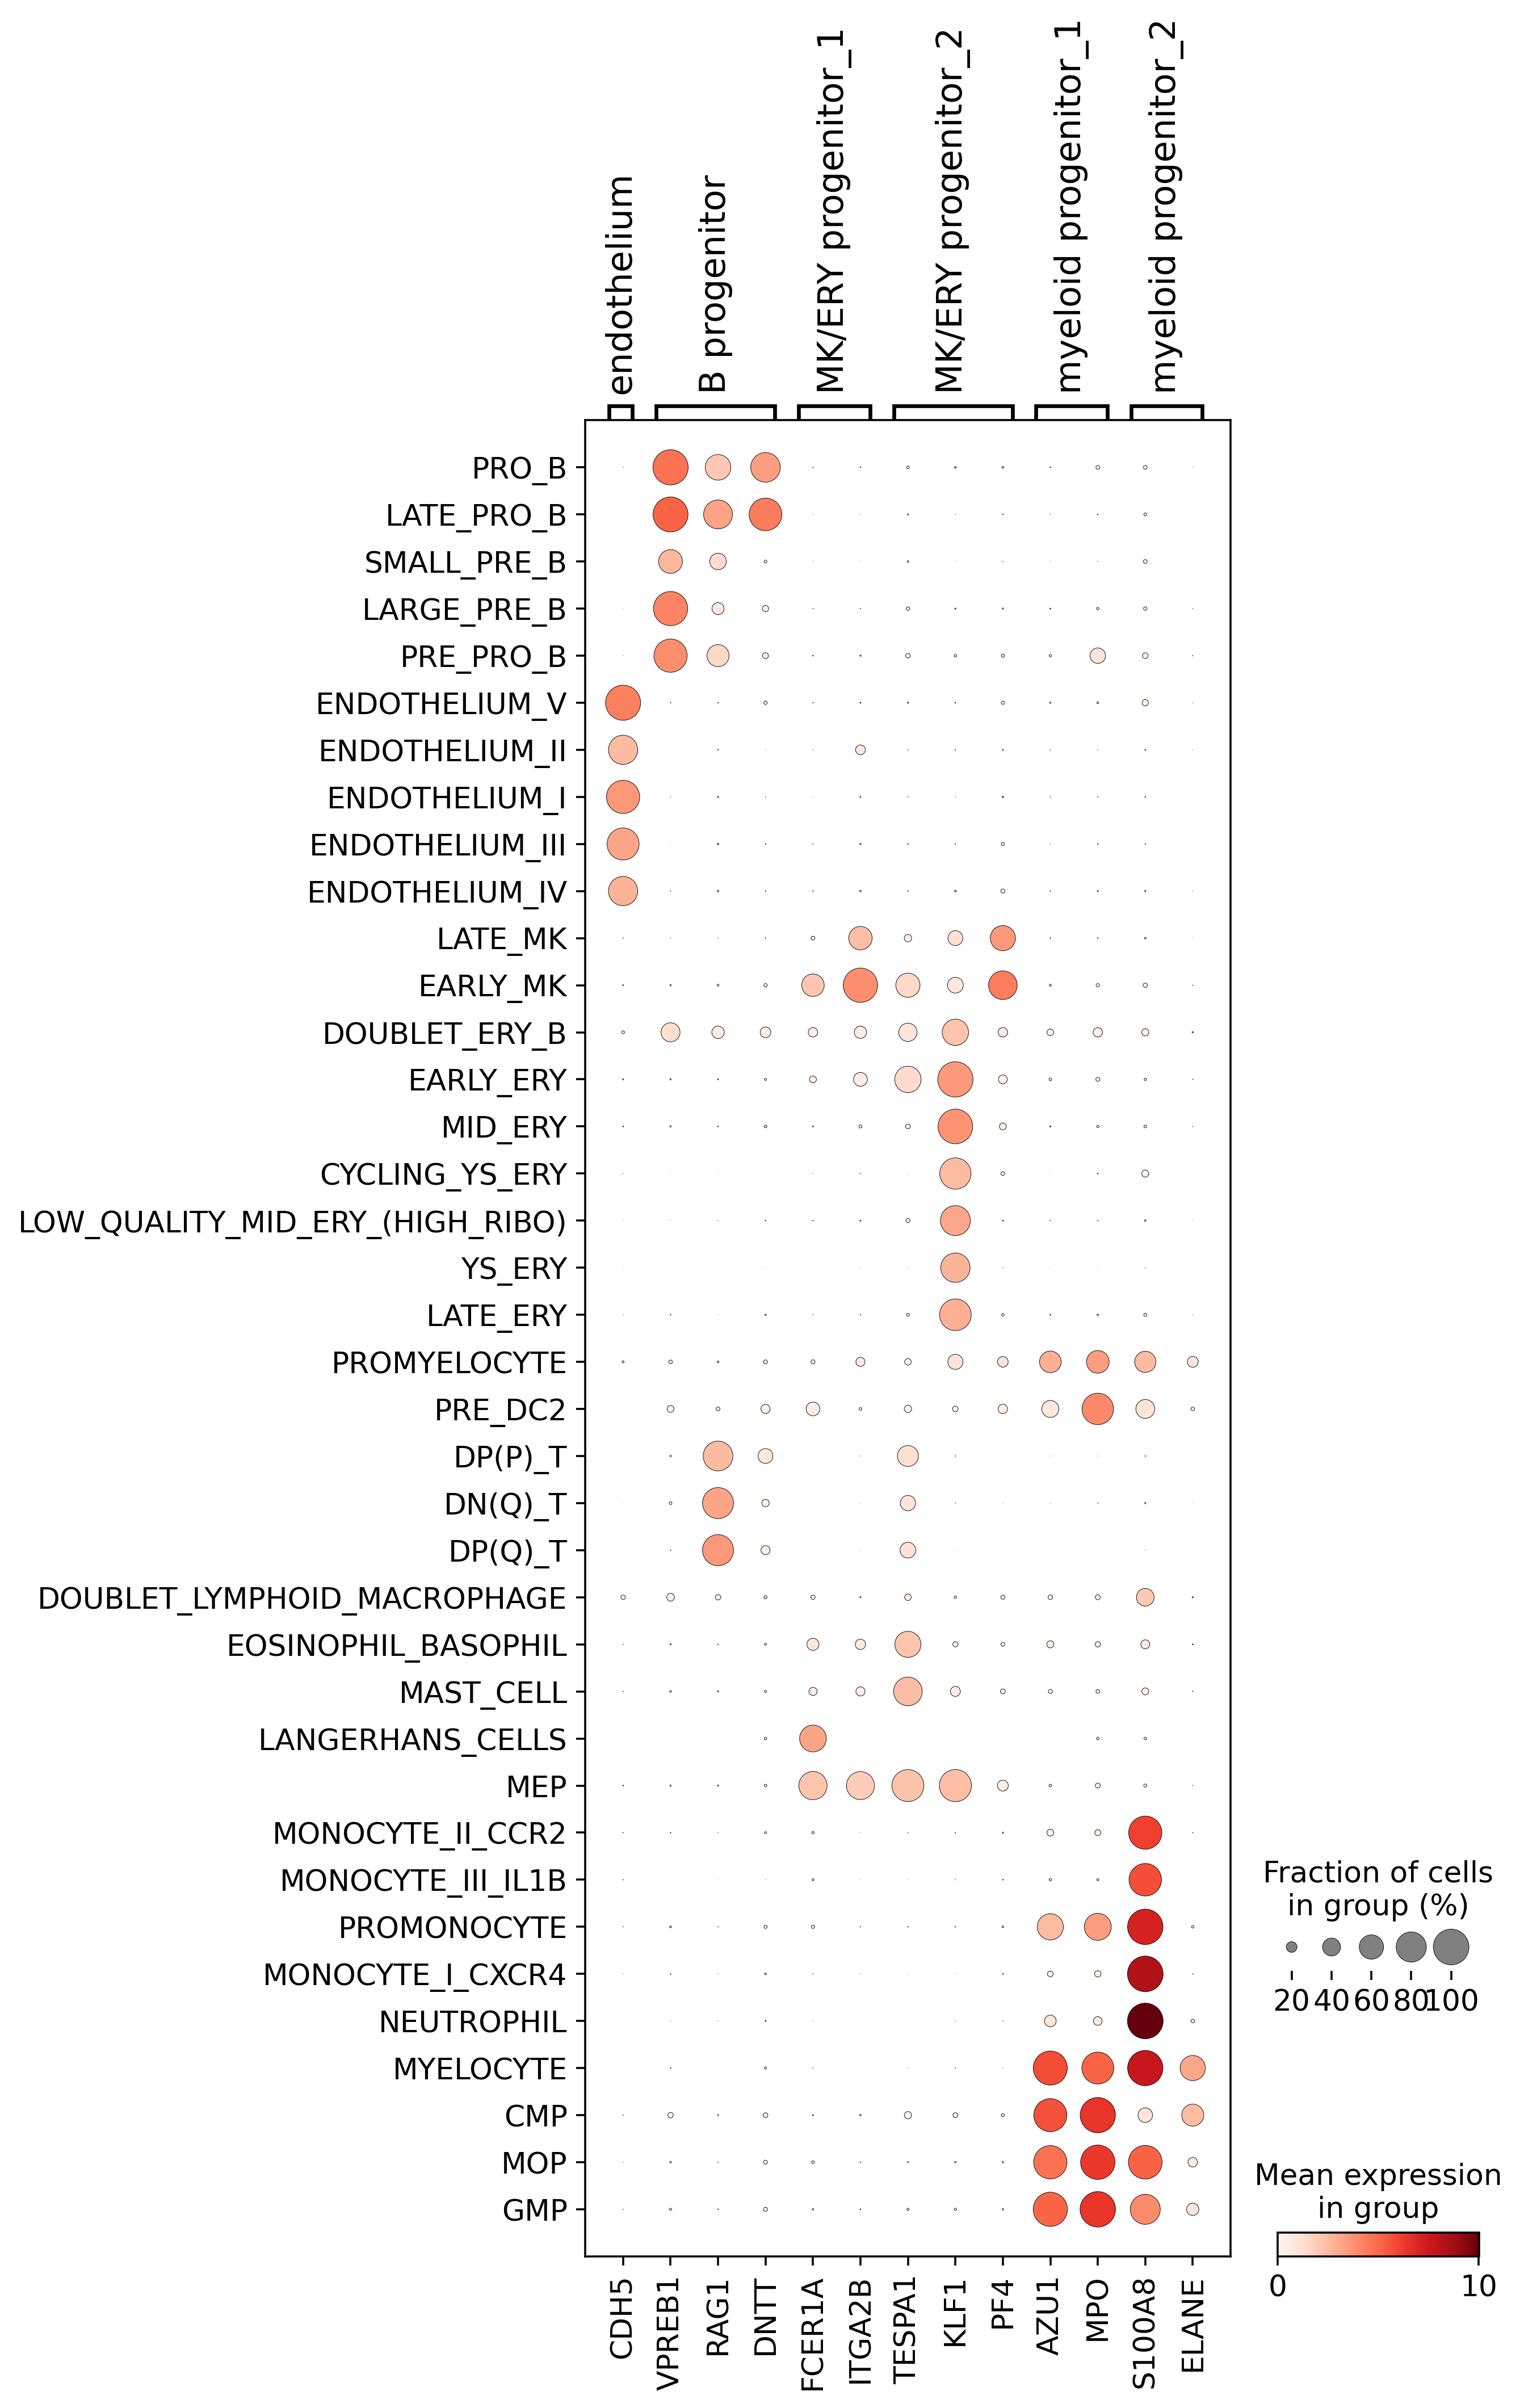

In [24]:
sc.pl.dotplot(adata_select, var_names = markers,groupby='anno_lvl_2_final_clean',swap_axes=False,save='rnascope_probes.png')

### B progenitors

In [33]:
genes = ['CDH5','VPREB1','RAG1','DNTT']

In [34]:
df = pd.DataFrame(index = set(adata.obs['anno_lvl_2_final_clean']), columns = genes)
for gene in df.columns:
    data_sl = adata[:,gene].X.todense()
    anno = adata.obs['anno_lvl_2_final_clean']
    for ct in df.index:
        df.loc[ct, gene]=np.mean(data_sl[anno==ct,])
df = df.fillna(0)   

In [40]:
# filter out cell types with maximum expression <2
df1 = df.loc[np.max(df,axis=1) >= 2,:]

In [41]:
## Cluster cell types 
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list
clustering = ward(df1.values)
ordered_index = df1.index[leaves_list(clustering)].tolist()
ordered_index = np.array(ordered_index)

In [42]:
# only plot the cell types with max expression >=2
adata_select = adata[adata.obs['anno_lvl_2_final_clean'].isin(ordered_index)]
adata_select.obs['anno_lvl_2_final_clean']=adata_select.obs['anno_lvl_2_final_clean'].astype('category')
adata_select.obs['anno_lvl_2_final_clean']=adata_select.obs['anno_lvl_2_final_clean'].cat.reorder_categories(ordered_index) # set categories of cell types to follow hierarchical clustering results

Trying to set attribute `.obs` of view, copying.


In [43]:
markers = {'endothelium':['CDH5'],
           'B progenitor':['VPREB1','RAG1','DNTT']
          }

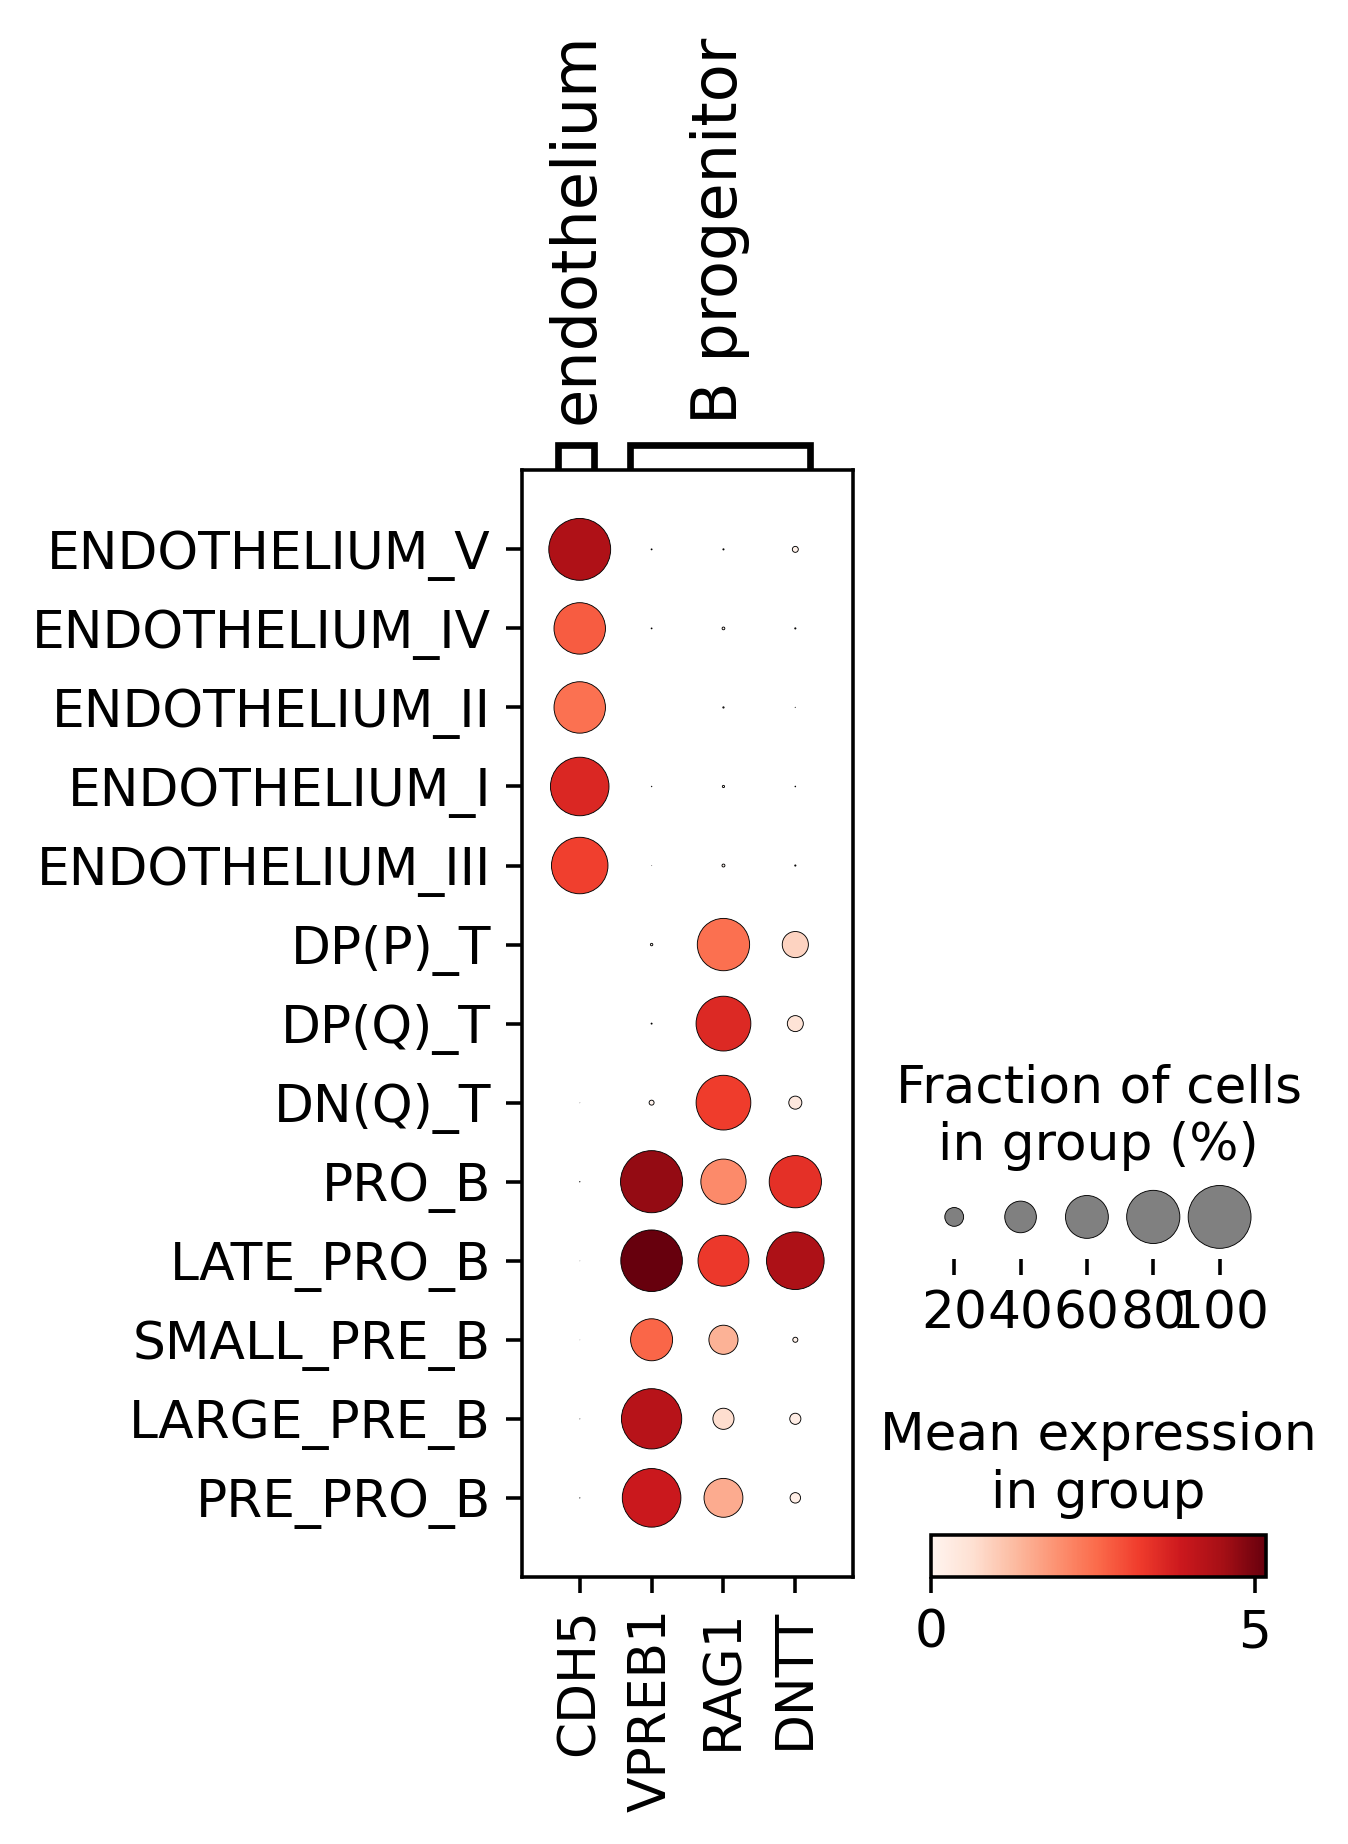

In [45]:
sc.pl.dotplot(adata_select, var_names = markers,groupby='anno_lvl_2_final_clean',swap_axes=False,save='rnascope_probes_BP.pdf')

### MEP

In [69]:
genes = ['CDH5','TESPA1','KLF1']

In [70]:
df = pd.DataFrame(index = set(adata.obs['anno_lvl_2_final_clean']), columns = genes)
for gene in df.columns:
    data_sl = adata[:,gene].X.todense()
    anno = adata.obs['anno_lvl_2_final_clean']
    for ct in df.index:
        df.loc[ct, gene]=np.mean(data_sl[anno==ct,])
df = df.fillna(0)   

In [71]:
# filter out cell types with maximum expression <2
df1 = df.loc[np.max(df,axis=1) >= 2,:]

In [72]:
df1 = df1.loc[~df1.index.isin(['LOW_QUALITY_MID_ERY_(HIGH_RIBO)','DOUBLET_ERY_B']),:] # remove low quality cells

In [73]:
## Cluster cell types 
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list
clustering = ward(df1.values)
ordered_index = df1.index[leaves_list(clustering)].tolist()
ordered_index = np.array(ordered_index)

In [74]:
# only plot the cell types with max expression >=2
adata_select = adata[adata.obs['anno_lvl_2_final_clean'].isin(ordered_index)]
adata_select.obs['anno_lvl_2_final_clean']=adata_select.obs['anno_lvl_2_final_clean'].astype('category')
adata_select.obs['anno_lvl_2_final_clean']=adata_select.obs['anno_lvl_2_final_clean'].cat.reorder_categories(ordered_index) # set categories of cell types to follow hierarchical clustering results

Trying to set attribute `.obs` of view, copying.


In [75]:
markers = {'endothelium':['CDH5'],
           'MK/ERY progenitor':['TESPA1','KLF1'],
          }

... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'organ' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'Sample' as categorical


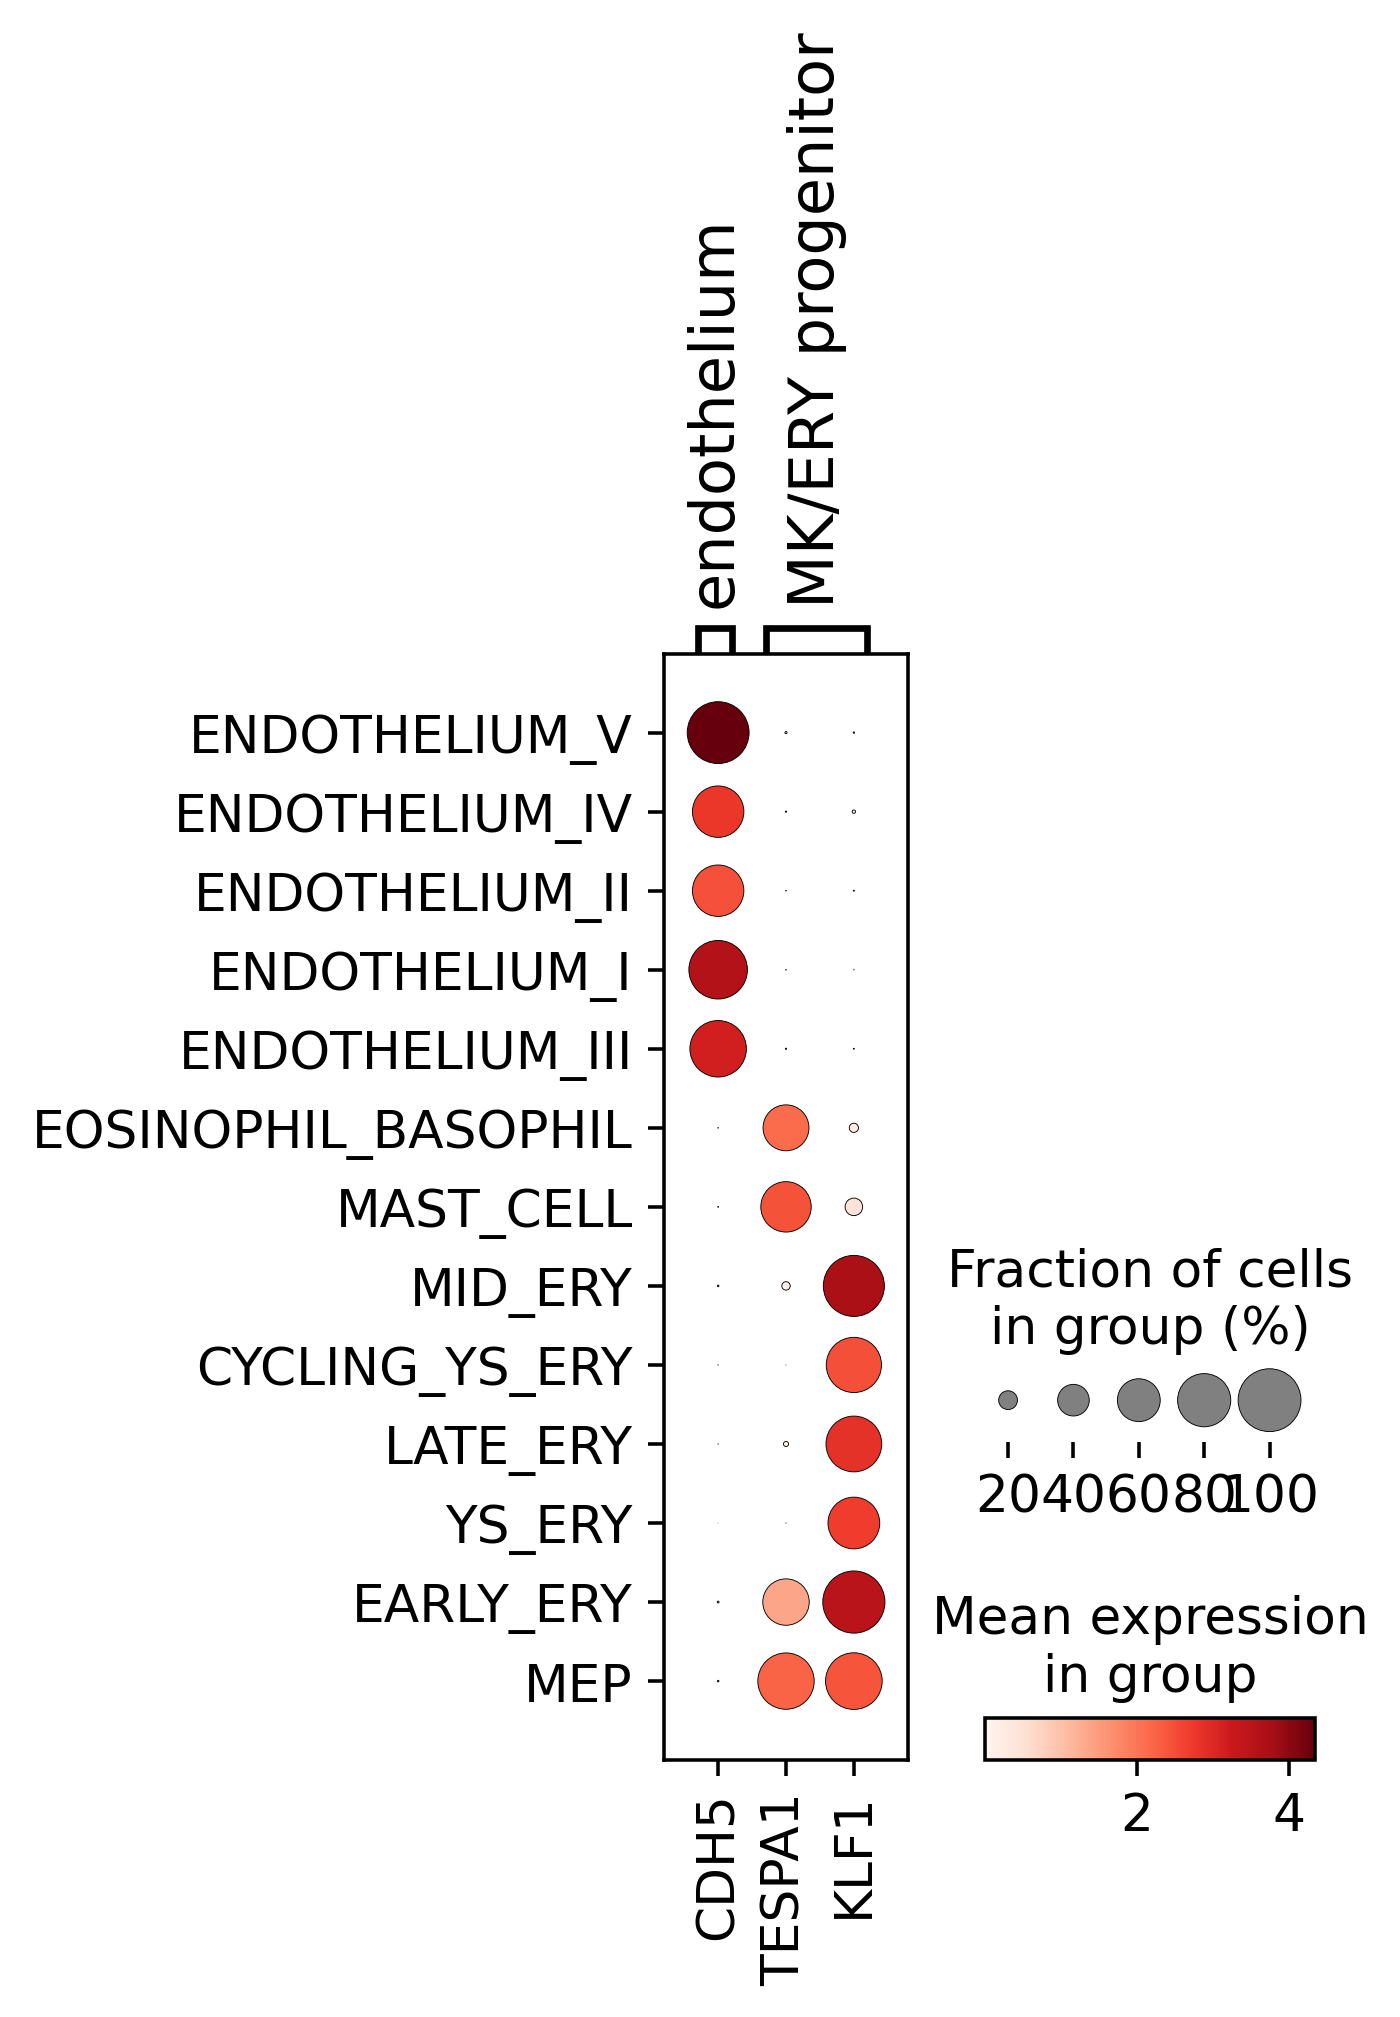

In [76]:
sc.pl.dotplot(adata_select, var_names = markers,groupby='anno_lvl_2_final_clean',swap_axes=False,save='rnascope_probes_MEP.pdf')

### MYP

In [59]:
genes = ['CDH5','AZU1','MPO']

In [60]:
df = pd.DataFrame(index = set(adata.obs['anno_lvl_2_final_clean']), columns = genes)
for gene in df.columns:
    data_sl = adata[:,gene].X.todense()
    anno = adata.obs['anno_lvl_2_final_clean']
    for ct in df.index:
        df.loc[ct, gene]=np.mean(data_sl[anno==ct,])
df = df.fillna(0)   

In [61]:
# filter out cell types with maximum expression <2
df1 = df.loc[np.max(df,axis=1) >= 2,:]

In [62]:
## Cluster cell types 
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list
clustering = ward(df1.values)
ordered_index = df1.index[leaves_list(clustering)].tolist()
ordered_index = np.array(ordered_index)

In [63]:
# only plot the cell types with max expression >=2
adata_select = adata[adata.obs['anno_lvl_2_final_clean'].isin(ordered_index)]
adata_select.obs['anno_lvl_2_final_clean']=adata_select.obs['anno_lvl_2_final_clean'].astype('category')
adata_select.obs['anno_lvl_2_final_clean']=adata_select.obs['anno_lvl_2_final_clean'].cat.reorder_categories(ordered_index) # set categories of cell types to follow hierarchical clustering results

Trying to set attribute `.obs` of view, copying.


In [66]:
markers = {'endothelium':['CDH5'],
           'myeloid progenitor':['AZU1','MPO'],
          }

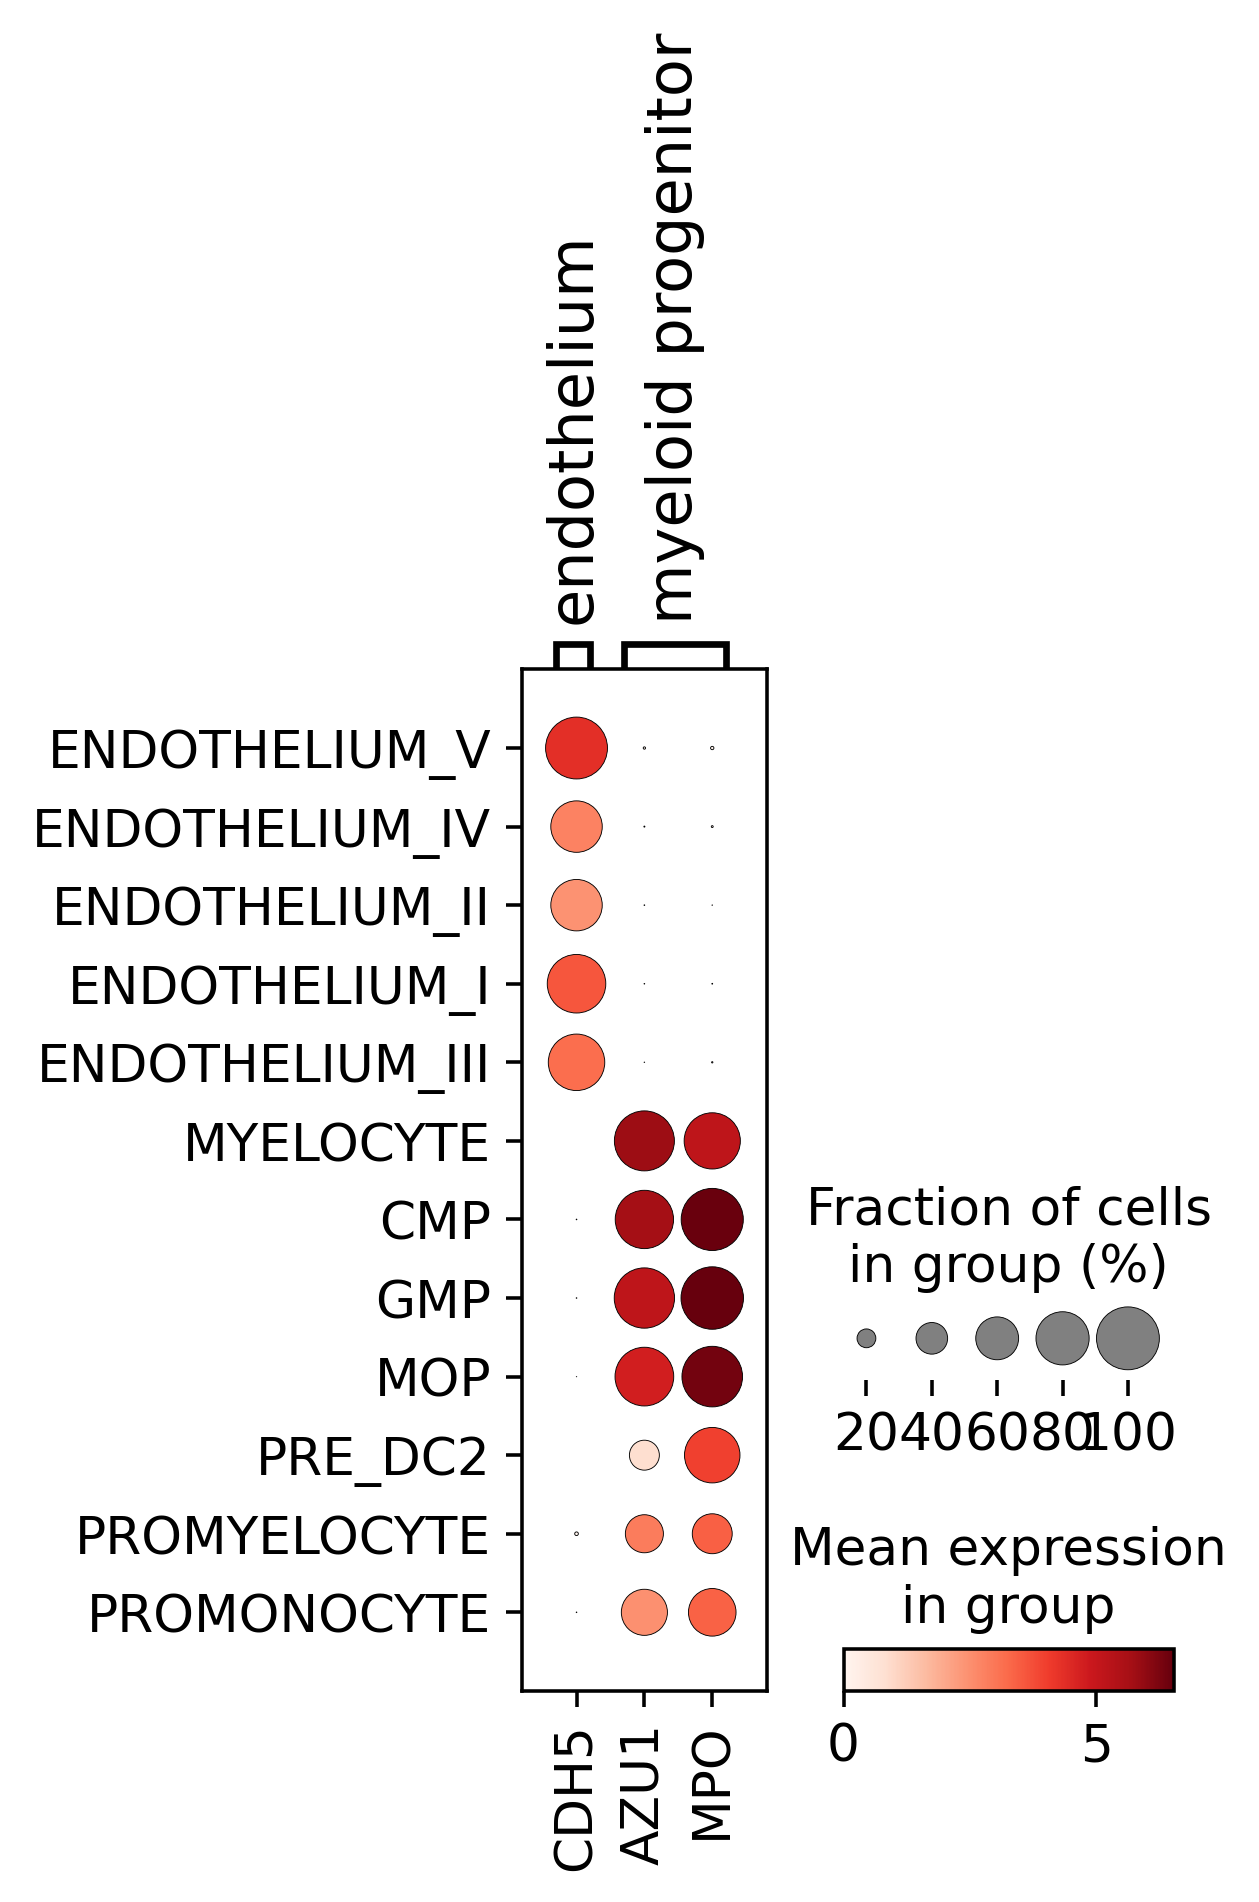

In [68]:
sc.pl.dotplot(adata_select, var_names = markers,groupby='anno_lvl_2_final_clean',swap_axes=False,save='rnascope_probes_MYP.pdf')